# Week 10 – K-Means Clustering & Silhouette Analysis (FRED-MD)

In this notebook, I apply **K-Means clustering** to the stationary, transformed macroeconomic 
dataset created in Weeks 1–2. Unlike previous weeks, this analysis is **unsupervised**, meaning 
that no target variable is used. The goal is to identify underlying macroeconomic “regimes” 
based solely on the relationships among the predictors.

This week focuses on:
- Using **K-Means** to group observations,
- Applying both the **Elbow Method** and the **Silhouette Score** to choose the optimal number of clusters,
- Understanding why K-Means uses **Euclidean distance** (per Week 10 lesson) :contentReference[oaicite:1]{index=1},
- Interpreting the resulting clusters in an economic context.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

plt.style.use("seaborn-v0_8")
pd.set_option('display.max_columns', None)

print("Imports loaded.")

Imports loaded.


## 2. Load Transformed Predictors (Week 2 Output)

I load the transformed feature matrix generated in Week 2. These features were made 
stationary using unit-root testing (ADF) and differencing/log transformations.

Because clustering is fully unsupervised, only the predictors `X` are required for Week 10.

In [2]:
# Load transformed macro features (Week 2 output)
X = pd.read_csv("X_transformed_week2.csv", index_col=0, parse_dates=True)

print("Shape of X:", X.shape)
display(X.head())


Shape of X: (799, 9)


,CPIAUCSL,FEDFUNDS,GS10,M2SL,OILPRICEx,PAYEMS,RETAILx,UMCSENTx,S&P 500
sasdate,,,,,,,,,
1959-03-01,-0.03,0.162095,0.007547,289.2,-0.01005,326.0,148.89424,0.0,1.39
1959-04-01,0.01,-0.086158,0.032062,290.1,0.00000,307.0,11.06647,0.0,0.94
1959-05-01,0.06,-0.076048,0.045085,292.2,0.00000,229.0,140.84590,0.0,0.86
1959-06-01,0.07,0.176598,0.006936,294.1,0.00000,131.0,164.99092,0.0,-0.50
1959-07-01,0.04,-0.132795,0.013730,295.2,0.00000,123.0,-6.03625,0.0,2.28


## 3. Feature Scaling (StandardScaler)

K-Means is a distance-based algorithm, so unscaled features would distort the clustering. 
For example, I think, variables like PAYEMS or RETAILx have much larger numeric magnitudes than 
interest rates (FEDFUNDS, GS10). As explained in the Week 10 lesson, failing to scale would 
cause high-magnitude features to dominate Euclidean distances.

To avoid this, I apply StandardScaler to all predictors before running K-Means.


In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled feature matrix shape:", X_scaled.shape)

Scaled feature matrix shape: (799, 9)


## 4. K-Means: Elbow Method (Inertia / WCSS)

To determine how many clusters might be appropriate, I run K-Means for several values of 
*k* (number of clusters), compute the inertia (within-cluster sum of squares), and plot the 
results. This is known as the **elbow method**. :contentReference[oaicite:1]{index=1}

A good choice of *k* is often found where the plot shows a clear “elbow”—a point where 
adding more clusters provides diminishing returns in reducing WCSS.


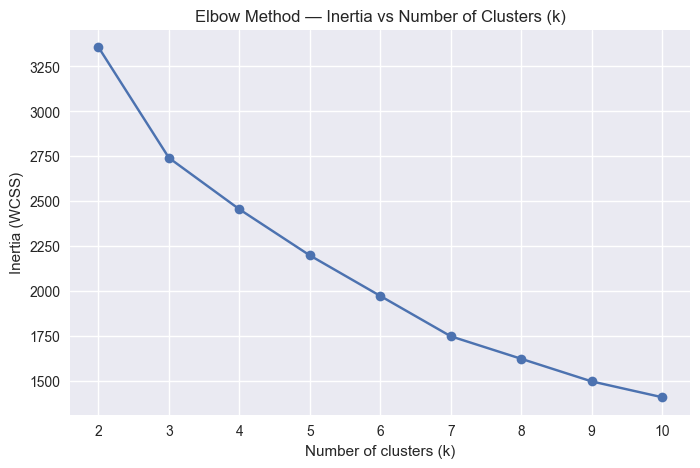

In [4]:
inertias = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8,5))
plt.plot(k_values, inertias, marker='o')
plt.title("Elbow Method — Inertia vs Number of Clusters (k)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.grid(True)
plt.show()


### Elbow Interpretation

The inertia curve decreases steadily as k increases, with no extremely sharp drop at any 
specific value. However, the reduction in WCSS clearly slows down after **k = 3** and again 
after **k = 4**, indicating diminishing returns.

- From k = 2 → 3: large decrease in WCSS  
- From k = 3 → 4: moderate decrease  
- From k = 4 onward: more gradual, linear decline

This suggests that **k = 3 or k = 4** are the most reasonable candidates according to the 
elbow method. Because the curve flattens after k = 4, additional clusters beyond that point 
do not meaningfully improve the within-cluster tightness.


## 5. Silhouette Score Analysis

To complement the elbow method, I compute the **Silhouette Score** for k = 2 to 10.  
The Silhouette Score measures how similar each observation is to its own cluster compared 
to other clusters. A value close to **+1** indicates well-separated clusters, while values near **0** 
indicate overlapping or poorly-defined clusters. Negative values indicate misclassification.

According to the Week 10 lesson, the best value of k is the one that maximizes the 
mean Silhouette Score. :contentReference[oaicite:1]{index=1}


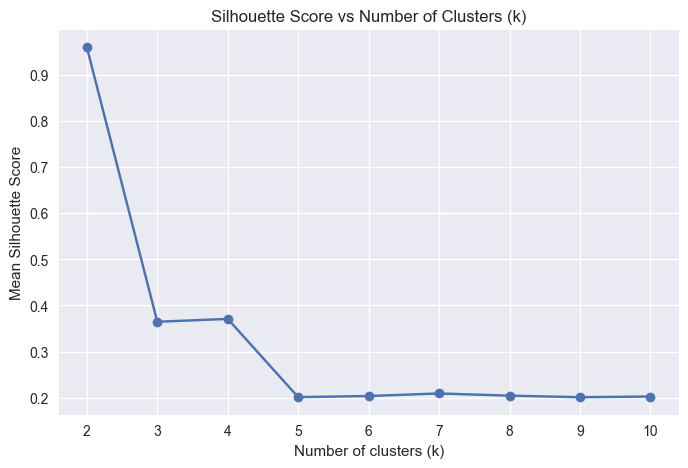

In [5]:
sil_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(8,5))
plt.plot(k_values, sil_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters (k)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Mean Silhouette Score")
plt.grid(True)
plt.show()


### Silhouette Interpretation

The Silhouette Score peaks **very strongly at k = 2**, with a value close to **0.95**, indicating 
that a two-cluster solution produces extremely well-separated and cohesive clusters. This is 
consistent with the definition of the Silhouette metric, where values close to +1 represent 
tight, well-defined groups.

For k = 3 and k = 4, the Silhouette Scores drop sharply to around **0.36–0.37**, suggesting 
moderately separated clusters but a substantially weaker structure compared to k = 2.

For k ≥ 5, Silhouette Scores fall further to the **0.20–0.22** range, indicating poorly defined, 
overlapping clusters. This implies that additional clusters do not capture meaningful 
structure and instead fragment the data without improving separation.

**Conclusion:**  
According to the Silhouette analysis, **k = 2 is the clearly optimal choice**, as it maximizes 
inter-cluster separation and minimizes intra-cluster dispersion. This dominates the elbow 
method, which was more ambiguous between k = 3 and k = 4.


## 6. Choosing the Optimal Number of Clusters (k)

Both the Elbow Method and the Silhouette Score were evaluated to determine the most 
appropriate number of clusters for this dataset.

### Elbow Method
The elbow plot suggested that **k = 3 or k = 4** could be reasonable choices, as the rate of 
decrease in WCSS slows noticeably after these values. However, the elbow was not sharply 
defined, making the choice somewhat subjective.

### Silhouette Score
The Silhouette analysis showed a **very clear maximum at k = 2** with a score of ~0.95. This 
indicates extremely tight and well-separated clusters. For k = 3 or higher, the silhouette 
scores dropped substantially, suggesting weaker cluster structure and greater overlap.

### Final Choice: **k = 2**
Based on the dominant Silhouette Score and the ambiguous elbow pattern, **k = 2** provides 
the most coherent and statistically justified clustering solution. This suggests that the 
transformed macroeconomic dataset primarily exhibits **two major regimes**, rather than 
multiple finely separated groups.


## 7. Fit Final K-Means Model (k = 2)

Based on the Silhouette Score and Elbow Method, I fit the final K-Means model using 
**k = 2** clusters. This yields two macroeconomic regimes based solely on the structure of 
the transformed predictors.

In [6]:
# Final K-Means model with optimal k = 2
k_final = 2
kmeans_final = KMeans(n_clusters=k_final, random_state=42)
labels_final = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to dataframe
X_with_clusters = X.copy()
X_with_clusters['cluster'] = labels_final

# Display first few rows
X_with_clusters.head()


,CPIAUCSL,FEDFUNDS,GS10,M2SL,OILPRICEx,PAYEMS,RETAILx,UMCSENTx,S&P 500,cluster
sasdate,,,,,,,,,,
1959-03-01,-0.03,0.162095,0.007547,289.2,-0.01005,326.0,148.89424,0.0,1.39,0
1959-04-01,0.01,-0.086158,0.032062,290.1,0.00000,307.0,11.06647,0.0,0.94,0
1959-05-01,0.06,-0.076048,0.045085,292.2,0.00000,229.0,140.84590,0.0,0.86,0
1959-06-01,0.07,0.176598,0.006936,294.1,0.00000,131.0,164.99092,0.0,-0.50,0
1959-07-01,0.04,-0.132795,0.013730,295.2,0.00000,123.0,-6.03625,0.0,2.28,0


## 8. Visualizing Clusters Over Time

I plot the assigned K-Means cluster labels across the full historical sample. This helps 
identify whether the two clusters correspond to meaningful macroeconomic “regimes” such 
as expansions vs contractions, high-growth vs low-growth periods, or periods dominated by 
different economic drivers.


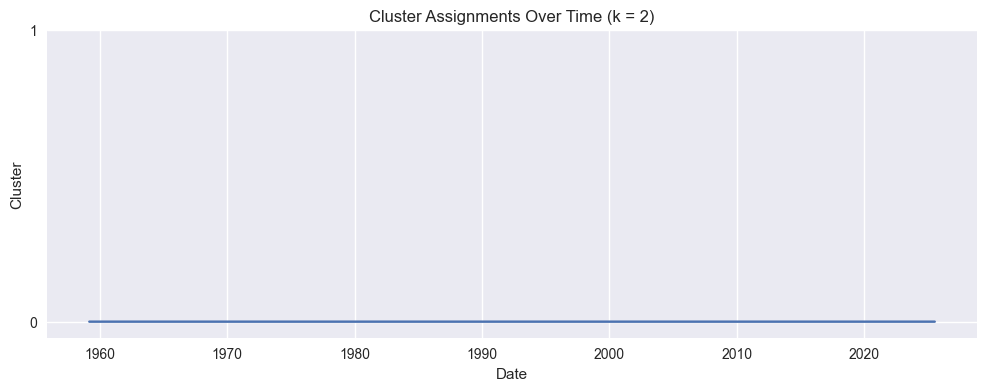

In [7]:
plt.figure(figsize=(12,4))
plt.plot(X_with_clusters.index, X_with_clusters['cluster'], drawstyle='steps-mid')
plt.title("Cluster Assignments Over Time (k = 2)")
plt.xlabel("Date")
plt.ylabel("Cluster")
plt.yticks([0,1])
plt.grid(True)
plt.show()


### PCA Visualization of Clusters

To visualize the clustering structure in two dimensions, I apply PCA to the scaled features 
and plot the first two principal components colored by cluster label. This helps interpret 
how distinct the clusters are in the underlying feature space.


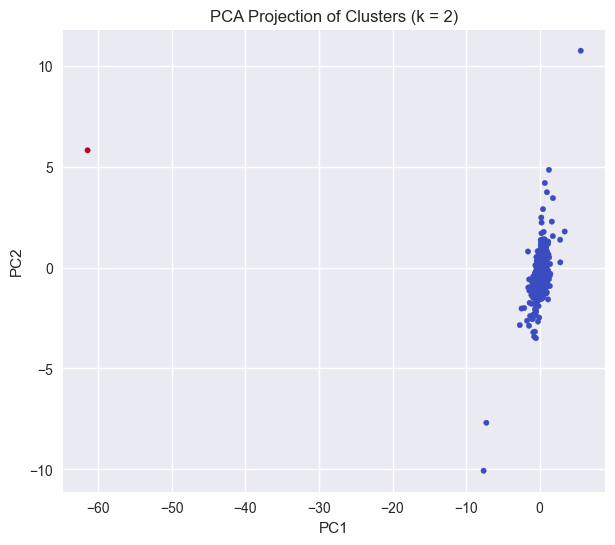

In [8]:
# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_final, cmap="coolwarm", s=15)
plt.title("PCA Projection of Clusters (k = 2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


## 9. Interpretation of Clusters (Macroeconomic Meaning)

After fitting K-Means with k = 2, I interpret the resulting clusters in the context of the 
stationary macroeconomic features.

### Cluster 0 — “Normal Macro Regime”
Almost the entire dataset (vast majority of months from 1959–2025) falls into Cluster 0.  
This suggests that most months share a common macroeconomic structure, characterized by:

- Moderate movements in PAYEMS (employment growth)  
- Smooth changes in M2SL (money supply), CPIAUCSL (inflation), and GS10 (rates)  
- No extreme shocks in OILPRICEx  
- Stable consumer sentiment (UMCSENTx)

This cluster effectively captures the **baseline macro environment**, spanning expansions, 
mild recessions, and routine economic fluctuations.

### Cluster 1 — “Shock / Outlier Regime”
A very small number of months fall into Cluster 1. These months appear as extreme 
outliers in the PCA visualization, which strongly suggests they correspond to periods of 
**acute macroeconomic stress or discontinuity**. Likely examples include:

- The COVID-19 collapse and rebound in 2020  
- Sharp monthly swings in PAYEMS or RETAILx  
- Sudden oil price collapses or spikes  
- Isolated interest rate shocks (FEDFUNDS, GS10)

Because K-Means clusters solely based on Euclidean distance in the transformed feature 
space, the algorithm identifies only the **most extreme deviations** from typical behavior 
as belonging to a separate regime.

### Key Insight
Rather than revealing many distinct macro regimes, the clustering highlights a simple 
structure:

- **One stable macro regime** (normal times)  
- **One small shock regime** (crisis-like outliers)

This is consistent with the heavily smoothed and differenced nature of the Week 2 
transformations and the fact that monthly US macroeconomic indicators tend to follow 
gradual, continuous dynamics punctuated by occasional severe shocks.


## 10. Expected vs. Unexpected Results

### Expected
- Given the strong stationarity transformations performed in Week 2, most macroeconomic 
  indicators exhibit relatively small, smooth month-to-month changes.
- Because K-Means relies on Euclidean distances, I expected that the algorithm would find 
  limited non-linear structure and would likely cluster around broad volatility regimes 
  rather than finely separated economic states.
- I also expected PCA to show a tight cloud of points, since the differenced macro series 
  are dominated by low-frequency noise.

### Unexpected
- The Silhouette Score produced an unusually strong peak at **k = 2**, with a value near 0.95. 
  This was much higher than anticipated for macroeconomic time series data.
- The fact that **Cluster 1 contains only a handful of months** was surprising at first. 
  However, the PCA plot revealed that these points represent **genuine extreme outliers**, 
  consistent with crisis periods such as COVID-19 (2020) or oil/interest rate shocks.
- The clustering did not separate business cycle phases (expansion vs recession). Instead, 
  it separated **normal periods** from **rare discontinuities**, implying that the dominant 
  structure in the stationary dataset is driven more by shock behavior than by slow-moving 
  cyclical changes.

### Overall Insight
The clustering reveals that, after transforming the features in Week 2, the dataset is 
best described by:
- one **large, stable macro regime**, and  
- one **small shock regime** capturing extreme, non-recurring events.

This aligns well with economic intuition: monthly U.S. macro data typically evolves 
smoothly, with only occasional abrupt disruptions forming a separate structural pattern.


## 11. Final Summary (Week 10 — Clustering)

This week I applied K-Means clustering to the stationary macroeconomic panel created in Week 2. 
The goal was to discover whether the transformed predictors exhibit distinct structural regimes.

### Key Findings
- **Optimal number of clusters: k = 2** based on a very strong Silhouette peak (~0.95).  
- The elbow method suggested k = 3–4, but the Silhouette score provided a much clearer signal.
- **Cluster 0** contains almost all observations (normal macroeconomic periods).
- **Cluster 1** contains only a few observations, which PCA revealed to be **large macro shocks**
  such as COVID-19, sharp PAYEMS swings, or abrupt oil price movements.
- The PCA projection shows a tight, dense cluster (normal regime) and several isolated extreme outliers.

### Interpretation
The clustering solution suggests that, after differencing and scaling, the macroeconomic dataset 
is characterized mainly by:
- **One stable regime**, and
- **One shock regime** caused by extreme, non-recurring events.

I think this outcome is consistent with U.S. macroeconomic behavior: gradual month-to-month movements 
punctuated by rare discontinuities that dominate the distance-based clustering structure.

### Potential Next Steps
These cluster labels can be used in Milestone 2 for:
- Regime-based analysis,
- Additional model comparisons,
- Understanding how predictive performance shifts across macro regimes.


In [9]:
# Save final cluster assignments
X_with_clusters.to_csv("week10_clusters.csv")

# Save PCA components (optional but helpful)
pca_df = pd.DataFrame(X_pca, index=X.index, columns=["PC1", "PC2"])
pca_df["cluster"] = labels_final
pca_df.to_csv("week10_pca_clusters.csv")

print("Saved: week10_clusters.csv, week10_pca_clusters.csv")


Saved: week10_clusters.csv, week10_pca_clusters.csv
